In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from linformer import Linformer
from vit_pytorch.efficient import ViT

cuda:0


In [2]:
torch.manual_seed(0)

In [3]:
dir_cat = "/home/hhg/Research/galaxyClassify/catalog/galaxyZoo/zoo2/"

file_csv = dir_cat+'gz2_all_v2.csv'
f_train = 0.64
f_valid = 0.16
f_test  = 0.20
seed = 3

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def data_split(file_csv, f_train=0.64, f_valid=0.16, f_test=0.20, random_state=None, stats=False, label_tag='label_8'):
    '''train-valid-test splits
        Args:
            file_csv (str) : path to the full catalog csv file
            f_train, f_valid, f_test : fractions of training, validation, test samples
            stats (bool): display splitting statistics if True 
        Returns:
            df_train (pd.dataframes) : splitted training sample
            df_valid (pd.dataframes) :          validation
            df_test  (pd.dataframes) :          test
    '''
    assert f_train + f_valid + f_test == 1, 'fractions have to sum to 1.'

    df = pd.read_csv(file_csv)

    df_train, df_temp = train_test_split(df, train_size=f_train, random_state=random_state)
    relative_f_valid = f_valid/(f_valid+f_test)
    df_valid, df_test = train_test_split(df_temp, train_size=relative_f_valid, random_state=random_state)
    
    if stats:
        df_stats=df.groupby([label_tag])[label_tag].agg('count').to_frame('count').reset_index()
        df_stats['full'] = df_stats['count']/df_stats['count'].sum()
        df_stats['train'] = df_train.groupby([label_tag]).size()/df_train.groupby([label_tag]).size().sum()
        df_stats['valid'] = df_valid.groupby([label_tag]).size()/df_valid.groupby([label_tag]).size().sum()
        df_stats['test'] = df_test.groupby([label_tag]).size()/df_test.groupby([label_tag]).size().sum()
        
        ax = df_stats.plot.bar(x=label_tag, y=['full', 'train', 'valid', 'test'], rot=0)
        ax.set_ylabel('class fraction')
    
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True), df_test.reset_index(drop=True)

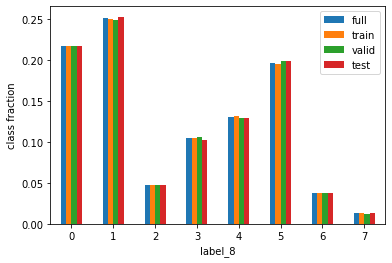

In [5]:
df_train, df_valid, df_test = data_split(file_csv, f_train, f_valid, f_test, random_state=seed, stats=True)

# Datasets

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset

class GalaxyZooDataset(Dataset):
    '''Galaxy Zoo 2 image dataset
        Args:
            dataframe : pd.dataframe, outputs from the data_split function
                e.g. df_train / df_valid / df_test
            dir_image : str, path where galaxy images are located
            label_tag : str, class label system to be used for training
                e.g. label_tag = 'label_8' / 'label_3'
    '''

    def __init__(self, dataframe, dir_image, label_tag='label_8', transform=None):
        self.df = dataframe
        self.transform = transform
        self.dir_image = dir_image
        self.label_tag = label_tag

    
    def __getitem__(self, index):
        galaxyID = self.df.iloc[[index]].galaxyID.values[0]
        file_img = os.path.join(self.dir_image, str(galaxyID) + '.jpg')
        image = Image.open(file_img)

        if self.transform:
            image = self.transform(image)
        
        label = self.df.iloc[[index]][self.label_tag].values[0]

        return image, label, int(galaxyID)

    def __len__(self):
        return len(self.df)

# Transforms

In [7]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    
    return train_transform, valid_transform, test_transform

# Train function

In [8]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            pred_logits = model(images)
            loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels, _ in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            # save the best model weights to Google drive
            torch.save(model.state_dict(), model_name+"_cache.pth")

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))

    # return the best model
    return model, history_dic

# Create Dataloaders

In [9]:
dir_image = '/home/hhg/Research/galaxyClassify/catalog/galaxyZoo_kaggle/gz2_images/images'

# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset(df_train, dir_image, label_tag='label_8', transform=train_transform)
data_valid = GalaxyZooDataset(df_valid, dir_image, label_tag='label_8', transform=valid_transform)
data_test  = GalaxyZooDataset(df_test , dir_image, label_tag='label_8', transform=test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


In [10]:
df_train.groupby(['label_8']).size()

label_8
0    21690
1    25064
2     4727
3    10502
4    13118
5    19490
6     3830
7     1387
dtype: int64

In [11]:
Ngals = np.array([21690., 25064., 4727., 10502., 13118., 19490., 3830., 1387.])
invNgals = 1./Ngals
invNgals /= invNgals[0]
print(invNgals)
#print(invNgals*4.6)

[ 1.          0.86538462  4.58853395  2.06532089  1.65345327  1.1128784
  5.66318538 15.63806777]


In [12]:
"""
Parameters
"""
PATCH_SIZE = 28
DEPTH = 12
HIDDEN_DIM = 128
K_DIM = 64
NUM_HEADS = 8

LR = 5e-4
STEP_SIZE = 200
GAMMA = 1
MAX_EPOCH = 200

LIN_DROPOUT = 0.1

# loss calculation for each class
class_weights = torch.FloatTensor([ 0.9, 1.,  4.6,  1.8,  2.5,  3.1, 8.2, 15.2]).to(device)
#class_weights = torch.FloatTensor([ 1., 1.,  4.6,  2.0,  2.5,  3., 8., 15.]).to(device)
#class_weights = torch.FloatTensor([ 1., 0.865,  4.589,  2.065,  1.653,  1.112, 5.663, 15.638]).to(device)
#class_weights = torch.FloatTensor([1., 1., 2., 1., 1., 1., 4., 3.]).to(device)
#class_weights = torch.FloatTensor([4.6, 4.0, 20.9, 9.6, 7.7, 5.1, 26.5, 73.3]).to(device)
#class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1.]).to(device)

In [13]:
## file name
model_name = "gz2_vit_09192021_1200"

# calculate seq_len
seq_len = int((224/PATCH_SIZE)**2) + 1

## Linformer
lin = Linformer(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = ViT(image_size=224, patch_size=PATCH_SIZE, num_classes=8, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=3)

# print out model details
print("*******[ " + model_name + " ]*******")
print("===============================")
print("patch_size = {}".format(PATCH_SIZE))
print("depth = {}".format(DEPTH))
print("hidden_dim = {}".format(HIDDEN_DIM))
print("k_dim = {}".format(K_DIM))
print("num_heads = {}".format(NUM_HEADS))
print("dropout = {}".format(LIN_DROPOUT))
print("batch_size = {}".format(BATCH_SIZE))
print("lr = {}".format(LR))
print("step_size = {}".format(STEP_SIZE))
print("gamma = {}".format(GAMMA))
print("max_epoch = {}".format(MAX_EPOCH))
print("class weights = {}".format(class_weights))
print("===============================")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("===============================")

*******[ gz2_vit_09192021_1200 ]*******
patch_size = 28
depth = 12
hidden_dim = 128
k_dim = 64
num_heads = 8
dropout = 0.1
batch_size = 64
lr = 0.0005
step_size = 200
gamma = 1
max_epoch = 200
class weights = tensor([ 0.9000,  1.0000,  4.6000,  1.8000,  2.5000,  3.1000,  8.2000, 15.2000],
       device='cuda:0')
Number of trainable parameters: 2785416


# Train the model

In [14]:
# move to gpu
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [15]:
## train and return the best model
model, history_dic = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10)

## Save the best weights
#torch.save(model.state_dict(), model_name + '.pth')
torch.save(model.state_dict(), model_name + '.pth')

## Convert history to dataframe
history_df = pd.DataFrame(history_dic)

## Save the history
#history_df.to_csv(model_name + '_history.csv')
history_df.to_csv(model_name + '_history.csv')

Epoch 1/200	Train loss: 1.4061	Train acc: 0.4885	Valid loss: 1.2929	Valid acc: 0.5769	Time: 6m 7s	<--
Epoch 2/200	Train loss: 1.2184	Train acc: 0.5787	Valid loss: 1.2067	Valid acc: 0.6006	Time: 6m 7s	<--
Epoch 3/200	Train loss: 1.1409	Train acc: 0.6139	Valid loss: 1.0793	Valid acc: 0.6381	Time: 6m 8s	<--
Epoch 4/200	Train loss: 1.0872	Train acc: 0.6385	Valid loss: 1.0275	Valid acc: 0.6519	Time: 6m 8s	<--
Epoch 5/200	Train loss: 1.0396	Train acc: 0.6550	Valid loss: 1.0033	Valid acc: 0.6714	Time: 6m 6s	<--
Epoch 6/200	Train loss: 1.0117	Train acc: 0.6640	Valid loss: 0.9722	Valid acc: 0.6984	Time: 6m 5s	<--
Epoch 7/200	Train loss: 0.9861	Train acc: 0.6752	Valid loss: 0.9496	Valid acc: 0.6953	Time: 6m 8s
Epoch 8/200	Train loss: 0.9663	Train acc: 0.6804	Valid loss: 0.9274	Valid acc: 0.7022	Time: 6m 6s	<--
Epoch 9/200	Train loss: 0.9473	Train acc: 0.6847	Valid loss: 0.8989	Valid acc: 0.7048	Time: 6m 11s	<--
Epoch 10/200	Train loss: 0.9291	Train acc: 0.6895	Valid loss: 0.9020	Valid acc: 0.674

# Plot loss and accuracy history

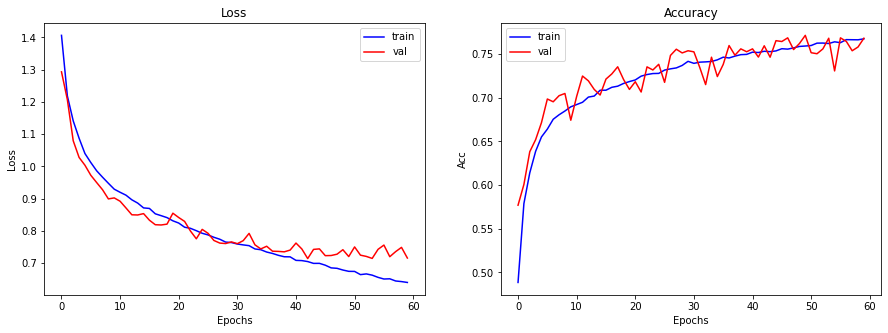

In [16]:
# read csv
history_df = pd.read_csv(model_name + '_history.csv')

# number of epochs
epochs = len(history_df['valid_acc'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_df['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_df['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_df['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_df['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()

# Predict test data

In [17]:
def predict_model(model):
    """
    Predict test data
    """
    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            pred_logits = model(images)
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            loss = criterion(pred_logits, labels)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    return y_true, y_pred, predict_df

In [18]:
# move to gpu
model = model.to(device)

# model evaluation
y_true, y_pred, predict_df = predict_model(model)

# save predict_df
predict_df.to_csv(model_name + '_predictions.csv')

In [19]:
predict_df.head()

,GalaxyID,class,pred
0,247139,4,4
1,199727,0,0
2,289754,6,6
3,213860,4,4
4,155041,4,4


# Evaluation matrix

Class 0: accuracy = 0.8331 (Round Elliptical)
Class 1: accuracy = 0.7615 (In-between Elliptical)
Class 2: accuracy = 0.7827 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.7803 (Edge-on Spiral)
Class 4: accuracy = 0.7237 (Barred Spiral)
Class 5: accuracy = 0.7442 (Unbarred Spiral)
Class 6: accuracy = 0.5189 (Irregular)
Class 7: accuracy = 0.7066 (Merger)
Total Accuracy = 0.7619

Recall = 0.7314

F1 score = 0.6968



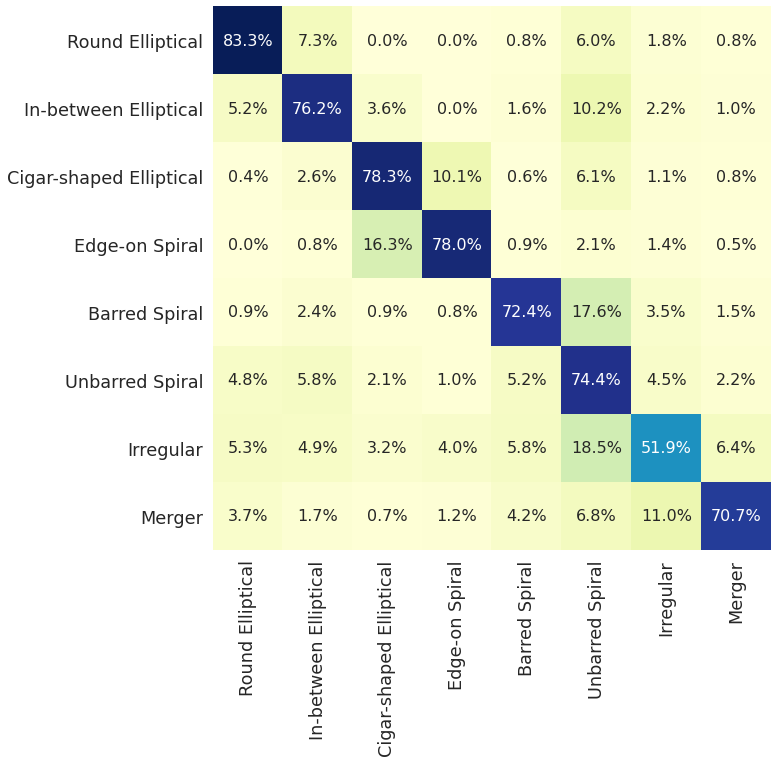

In [20]:
# galaxy classes
gxy_labels = ['Round Elliptical',
              'In-between Elliptical',
              'Cigar-shaped Elliptical',
              'Edge-on Spiral',
              'Barred Spiral',
              'Unbarred Spiral',
              'Irregular',
              'Merger']

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

# accuracy of each class
for c in range(8):
    print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
print("================")

# accuracy
acc = accuracy_score(y_true, y_pred)
print("Total Accuracy = {:.4f}\n".format(acc))

# recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall = {:.4f}\n".format(recall))

# f1 score
F1 = f1_score(y_true, y_pred, average='macro')
print("F1 score = {:.4f}\n".format(F1))

# plot confusion matrix
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
plt.show()